# Milestone 2

## Author - Nourhan El Zarif



## Dataset

The dataset used in this data exploration is Kaggle King County house sales dataset
https://www.kaggle.com/harlfoxem/housesalesprediction

In [1]:
# Load necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import scipy.stats
%matplotlib inline

In [2]:
# Location of dataset
file = 'https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/kc_house_data.csv'
kc_house= pd.read_csv(file)

In [3]:
kc_house.shape

(21613, 21)

# Part 1: Identify a likely distribution for price and several other features.

## Price
The distribution of the prices of homes in king county appears to be an log normal distribution according to this histogram. We will test this with a QQ plot. 

Text(0.5, 0, 'Price')

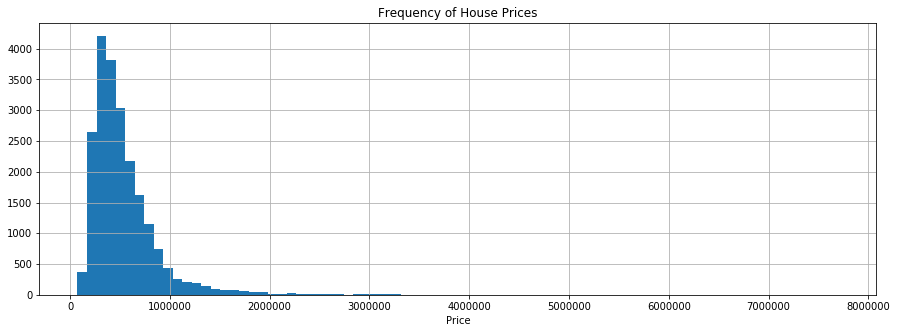

In [4]:
kc_house.loc[:, 'price'].hist(bins = 80, ax= plt.figure(figsize= (15, 5)).gca())
plt.title('Frequency of House Prices')
plt.xlabel('Price')

The QQ plot below shows many data point lying on the diagonal line. There is a small distance between the line and the points that aren't on the line. The price appears to have a log normal distribution.

Text(0.5, 1.0, 'Q-Q Plot of Price/Log Normal Dist')

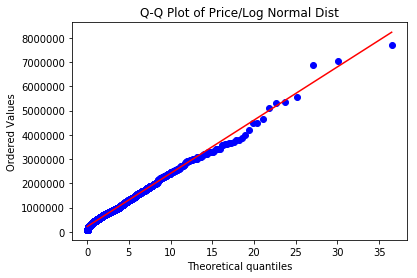

In [5]:
ss.probplot(kc_house.loc[:, 'price'], dist=ss.lognorm(s=0.9) ,plot=plt)
plt.title('Q-Q Plot of Price/Log Normal Dist')

## Sqft of Living Space
The distribution of square footage also appears to be log normal.

Text(0.5, 0, 'Area in sqft')

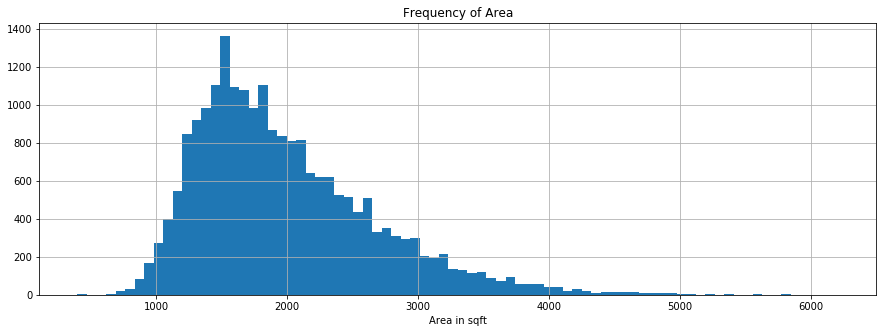

In [6]:
kc_house.loc[:, 'sqft_living15'].hist(bins = 80, ax= plt.figure(figsize= (15, 5)).gca())
plt.title('Frequency of Area')
plt.xlabel('Area in sqft')

The QQ plot below shows that the square footage of homes in King county has a log normal distribution. The majority of the points are on the diagonal line, and there are very few outliers.

Text(0.5, 1.0, 'Q-Q Plot of Areat/Log Normal Dist')

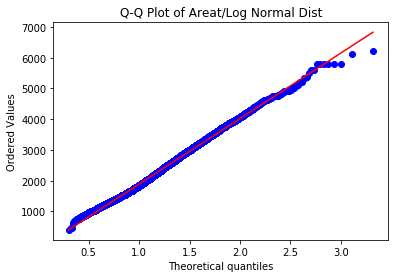

In [7]:
ss.probplot(kc_house.loc[:, 'sqft_living15'], dist=ss.lognorm(s=0.3), plot=plt)
plt.title('Q-Q Plot of Areat/Log Normal Dist')

# Part 2-4: Compute basic summary statistics & confidence intervals & determine if the differences in pairs and multiple populations are significant

## Waterfront

### T-Test (Classical)

In [8]:
def t_test(a, b, alpha, alternative='two-sided'):
    import statsmodels.stats.weightstats as ws
    
    diff = a.mean() - b.mean()

    res = ss.ttest_ind(a, b, equal_var=False)
      
    means = ws.CompareMeans(ws.DescrStatsW(a), ws.DescrStatsW(b))
    confint = means.tconfint_diff(alpha=alpha, alternative=alternative, usevar='unequal') 
    degfree = means.dof_satt()

    index = ['DegFreedom', 'Difference', 'Statistic', 'PValue', 'Low95CI', 'High95CI']
    return pd.Series([degfree, diff, res[0], res[1], confint[0], confint[1]], index = index)  

from statistics import mean

def hist_plot(vec, bins):
    plt.hist(vec, bins = bins)
    plt.axvline(mean(vec), color = 'red')
    plt.ylabel('Frequency')
    plt.xlabel('Value')

def hist_mean_ci(vec, t_test, bins):
    upper = mean(vec) + t_test[5] - t_test[1]
    lower = mean(vec) + t_test[4] - t_test[1]
    plt.hist(vec, bins = bins)
    plt.axvline(mean(vec), color = 'red')
    plt.axvline(upper, color = 'red', linestyle='--')
    plt.axvline(lower, color = 'red', linestyle='--')
    plt.ylabel('Frequency')
    plt.xlabel('Value')

def plot_t(a, b, t_test, cols=['pop_A', 'pop_B'], nbins = 20):
    minx = min([min(a), min(b)])
    maxx = max([max(a), max(b)])
    stepx = (maxx - minx)/(nbins + 1)
    bins = [minx + i * stepx for i in range(nbins + 1)]
    plt.subplot(2, 1, 1) # The first plot
    hist_mean_ci(a, t_test, bins)
    plt.title('Histogram of ' + cols[0] + ' and ' + cols[1])
    plt.subplot(2, 1, 2) # The next plot
    hist_plot(b, bins)
    
#We want a large sample to get a good representation of the population, but there are only 195 rows. 
#I will stratify the data, and make the size of the sample equal to the size of the smallest strata.
def stratify_by(df, group):
    #getting the size of the type with the lowest count
    size = df[group].value_counts().min()
    print('The sample size of each strata in ' + str(group) + ' is ' + str(size))
    
    groups = df.groupby([group])
    return groups.apply(lambda x: x.sample(n=size))

In [9]:
waterfront = stratify_by(kc_house, 'waterfront')
waterfront.reset_index(inplace=True, drop=True)

The sample size of each strata in waterfront is 163


In [10]:
water = waterfront.loc[waterfront.loc[:,'waterfront'] == 1,'price']
noWater = waterfront.loc[waterfront.loc[:,'waterfront'] == 0,'price']

The T-test below demonstrates the diference in means is significant. The T-statistic is large, and the p-value is less than 0.05, and very close to 0. The confidence intervals do not straddle 0. 

The histogram below visually shows us that the mean of house prices without a waterfront does not fall within the confidence intervals of house prices with a waterfront. 

Due to all these conditions, we can reject the null hypothesis that difference in means for the prices of houses with/without a waterfront arrises from randomness. 

DegFreedom    1.758513e+02
Difference    1.178035e+06
Statistic     1.314569e+01
PValue        6.197228e-28
Low95CI       1.001178e+06
High95CI      1.354892e+06
dtype: float64


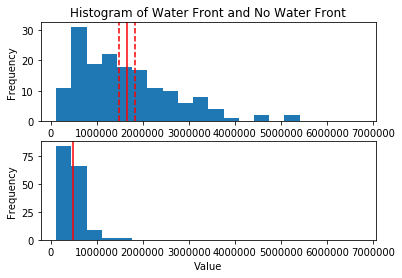

In [11]:
test = t_test(water, noWater, 0.05)
print(test)
plot_t(water, noWater, test, cols = ['Water Front', 'No Water Front'])

### Bootstrap
Now we will compare the difference in means for house with/without a waterfront using the Bootstrap method.

In [12]:
def plot_hist(x, p=5):
    # Plot the distribution and mark the mean
    plt.hist(x, alpha=.5)
    plt.axvline(x.mean())
    # 95% confidence interval    
    plt.axvline(np.percentile(x, p/2.), color='red', linewidth=3)
    plt.axvline(np.percentile(x, 100-p/2.), color='red', linewidth=3)


def plot_dists(a, b, nbins, a_label='pop_A', b_label='pop_B', p=5):
    # Create a single sequence of bins to be shared across both
    # distribution plots for visualization consistency.
    combined = pd.concat([a, b])
    breaks = np.linspace(
        combined.min(), 
        combined.max(), 
        num=nbins+1)

    plt.subplot(2, 1, 1)
    plot_hist(a)
    plt.title(a_label)
    
    plt.subplot(2, 1, 2)
    plot_hist(b)
    plt.title(b_label)
    
    plt.tight_layout()

In [13]:
n = 1000

water = pd.Series([
    kc_house[kc_house.waterfront == 1].sample(frac=1, replace=True).price.mean()
    for i in range(n)
])

noWater = pd.Series([
    kc_house[kc_house.waterfront == 0].sample(frac=1, replace = True).price.mean()
    for i in range(n)
])

The histogram below shows that the mean price for houses with a waterfront are 1.1 million dollars more than the mean price for houses without one. The confidence intervals for both distributions do not overlap. 

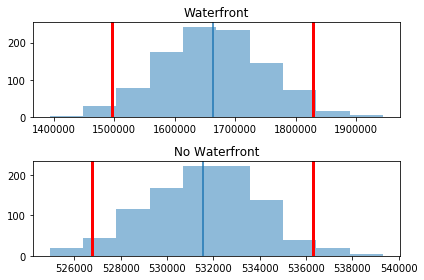

In [14]:
plot_dists(water, noWater, nbins=80, a_label='Waterfront', b_label='No Waterfront')

The plot below shows that the average difference in means is 1.15m dollars. The confidence interval does not straddle 0. We can reject the null hypothesis that the difference in means arrises from randomness. 

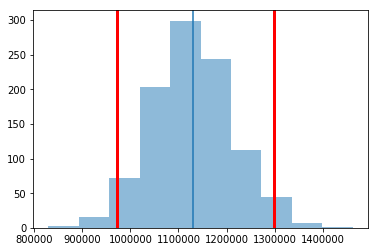

In [15]:
diffs = []
for i in range(n):
    sample = kc_house.sample(frac=1.0, replace=True)
    wtr_sample_mean = sample[sample['waterfront'] == 1].price.mean()
    nwr_sample_mean = sample[sample['waterfront'] == 0].price.mean()
    diffs.append(wtr_sample_mean - nwr_sample_mean)
diffs = pd.Series(diffs)

plot_hist(diffs)

### Bayesian Method

In [16]:
def comp_like(p, x): 
    variance = np.std(x)**2 # sigmasqr
    x_mean = np.asarray(x).mean()  # xbar
    print('Mean = %.3f, Standard deviation = %.3f' % (x_mean, np.std(x)))
    n = len(x)
    l = np.exp(-n * np.square(x_mean - p) / (2 * variance))
    return l / l.sum()


def posterior(prior, like):
    post = prior * like # compute the product of the probabilities
    return post / sum(post) # normalize the distribution to sum to unity


def plot_post(prior, like, post, x):
    maxy = max(max(prior), max(like), max(post))
    plt.figure(figsize=(12, 4))
    plt.plot(x, like, label='likelihood', linewidth=12, color='black', alpha=.2)
    plt.plot(x, prior, label='prior')
    plt.plot(x, post, label='posterior', color='green')
    plt.ylim(0, maxy)
    plt.xlim(0, 1)
    plt.title('Density of prior, likelihood and posterior')
    plt.xlabel('Parameter value')
    plt.ylabel('Density')
    plt.legend()
    
num_samples = 100000
lower_q, upper_q = [.025, .975]

def plot_ci(p, post, num_samples, lower_q, upper_q):
    ## This function computes a credible interval using an assumption
    ## of symetry in the bulk of the distribution to keep the 
    ## calculation simple. 
    ## Compute a large sample by resampling with replacement
    samples = np.random.choice(p, size=num_samples, replace=True, p=post)
    ci = scipy.percentile(samples, [lower_q*100, upper_q*100]) # compute the quantiles
    
    interval = upper_q - lower_q
    plt.title('Posterior density with %.3f credible interval' % interval)
    plt.plot(p, post, color='blue')
    plt.xlabel('Parameter value')
    plt.ylabel('Density')
    plt.axvline(x=ci[0], color='red')
    plt.axvline(x=ci[1], color='red')
    print('The %.3f credible interval is %.3f to %.3f' 
          % (interval, lower_q, upper_q))

Mean = 1668192.450, Standard deviation = 1123666.783
Mean = 540780.400, Standard deviation = 389890.213
The 0.950 credible interval is 0.025 to 0.975
The 0.950 credible interval is 0.025 to 0.975


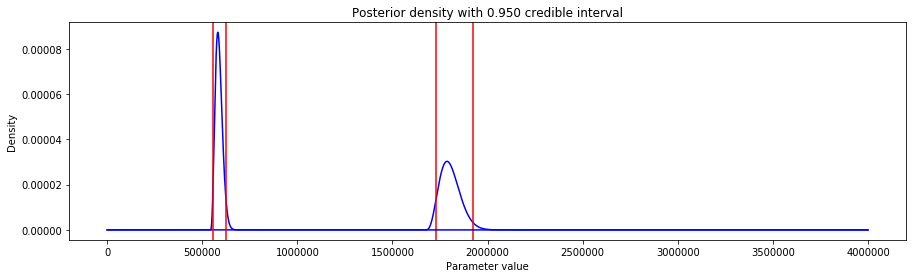

In [17]:
N = 1000000
p = np.linspace(0, 4000000, num=N)

num_samples = 160


wtr_sample = kc_house[kc_house.waterfront == 1].sample(n=num_samples)
nwr_sample = kc_house[kc_house.waterfront == 0].sample(n=num_samples)

like_wtr = comp_like(p, wtr_sample.price)
pp_wtr = ss.lognorm.pdf(p, s=0.9, loc = wtr_sample.price.mean() , scale=wtr_sample.price.std())
pp_wtr = pp_wtr/pp_wtr.sum()
post_wtr = posterior(pp_wtr, like_wtr)

like_nwr = comp_like(p, nwr_sample.price)
pp_nwr = ss.lognorm.pdf(p, s=0.9, loc = nwr_sample.price.mean(), scale=nwr_sample.price.std())
pp_nwr = pp_nwr/pp_nwr.sum()
post_nwr = posterior(pp_nwr, like_nwr)

plt.figure(figsize=(15,4)).gca()
# Plotting the Posterior distributions and CIs
plot_ci(p, post_wtr, num_samples, lower_q=.025, upper_q=.975)
plot_ci(p, post_nwr, num_samples, lower_q=.025, upper_q=.975)

The Bayesian method shows the posterier densities of homes with and without waterfronts. The graph demonstrates that the distributions do not overlap, and the confidence intervals do not overlap. Due to these reasons, we can reject the null hypothesis that the difference of means of homes with and without waterfronts arrises from randomness.

This example shows that all tree tests reject the null hypothesis


## Condition (Tukey HSD)

Text(0.5, 0, 'Condition')

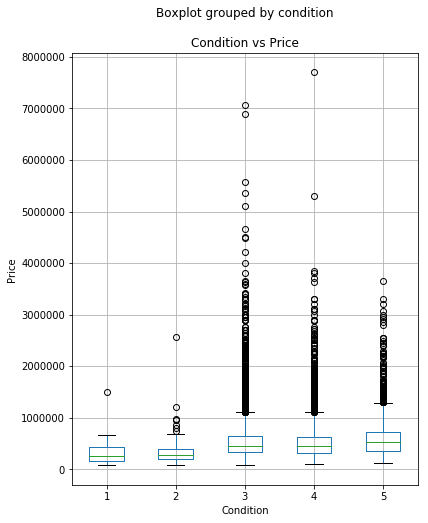

In [18]:
ax = plt.figure(figsize=(6,8)).gca()
kc_house.loc[:, ['price', 'condition']].boxplot(by = ['condition'], ax=ax)
ax.set_title('Condition vs Price')
ax.set_ylabel('Price')
ax.set_xlabel('Condition')

Looking at the box plot above, it is very difficult to distinguish differences in means between the 5 house conditions. 

After running the Tukey HSD test we can make pairwise comparisons. Only one of the ten combinations has an insignificant difference in means. The confidence interval straddles 0. We cannot reject the null hypothesis for conditions 1 or 2. 

The other 9 combinations have a significance in te difference in mean price. The confidence intervals do not straddle 0. We can reject the null hypothesis that the difference in means for different house conditions arises from randomness.

In [19]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

hsd = pairwise_tukeyhsd(kc_house.loc[:, 'price'], kc_house.loc[:, 'condition'])
print(hsd)

    Multiple Comparison of Means - Tukey HSD,FWER=0.05   
group1 group2   meandiff     lower        upper    reject
---------------------------------------------------------
  1      2     -7144.5213 -204636.9684 190347.9258 False 
  1      3    207580.9115  25148.1544  390013.6686  True 
  1      4    186768.7234  4049.9727    369487.474  True 
  1      5    277986.4227  94148.3717  461824.4737  True 
  2      3    214725.4328 138151.4626   291299.403  True 
  2      4    193913.2447 116660.3879  271166.1015  True 
  2      5     285130.944 205266.7403  364995.1477  True 
  3      4    -20812.1881 -36510.8531   -5113.5231  True 
  3      5     70405.5112  44778.6653   96032.3571  True 
  4      5     91217.6993  63628.4587   118806.94   True 
---------------------------------------------------------


## Number of Bedrooms
The bar plot below show that 3 and 4 bedroom homes are the most commonly available. We will see if the difference of means is significant. 

Text(0.5, 1.0, 'Frequency of Bedrooms')

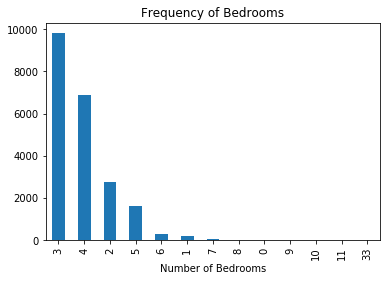

In [20]:
kc_house['bedrooms'].value_counts().plot.bar()
plt.xlabel('Number of Bedrooms')
plt.title('Frequency of Bedrooms')

### T-Test (Classical)

In [21]:
#creating a dataframe containing only 3 or 4 bedroom homes 
home = pd.DataFrame(data= kc_house[kc_house.bedrooms == 3])
home = home.append(kc_house[kc_house.bedrooms == 4])

home.reset_index(inplace=True, drop=True)
home.shape

(16706, 21)

In [22]:
home['bedrooms'].value_counts()

3    9824
4    6882
Name: bedrooms, dtype: int64

In [23]:
#stratifying my data 
bedroom_strata = stratify_by(home, 'bedrooms')
bedroom_strata.reset_index(inplace=True, drop=True)

The sample size of each strata in bedrooms is 6882


The T-test below shows that the diffwrence in means is significant. The difference in mean price of a 3 and 4 bedroom home is ~ 150,000 dollars. The t-statistic is very large. The P-value is less than 0.05, and very close to 0. The Confidence interval also does not straddle 0. 

The histogram shows that the mean of the 4-bedroom homes does not fall within the confidence intervals of the 3-bedroom homes. 

We can reject the null hypothesis that the difference in means of 3 and 4 bedroom homes arrises from randomness.

DegFreedom     1.205452e+04
Difference    -1.686825e+05
Statistic     -2.987319e+01
PValue        3.129317e-189
Low95CI       -1.797507e+05
High95CI      -1.576142e+05
dtype: float64


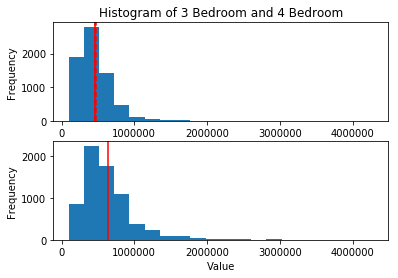

In [24]:
bed3= bedroom_strata.loc[bedroom_strata.loc[:, 'bedrooms'] == 3, 'price']
bed4= bedroom_strata.loc[bedroom_strata.loc[:, 'bedrooms'] == 4, 'price']

test = t_test(bed3, bed4, 0.05)
print(test)
plot_t(bed3, bed4, test, cols = ['3 Bedroom', '4 Bedroom'])

## Bootstrap

In [25]:
n = 5000

bed3 = pd.Series([
    home[home.bedrooms == 3].sample(frac=1, replace=True).price.mean()
    for i in range(n)
])

bed4 = pd.Series([
    home[home.bedrooms == 4].sample(frac=1, replace = True).price.mean()
    for i in range(n)
])

The histogram below the means and confidence intervals of 3 and 4 bedroom homes. The upper CI of the 3 bedroom homes does not overlap with the lower CI of the 4 bedroom homes. 

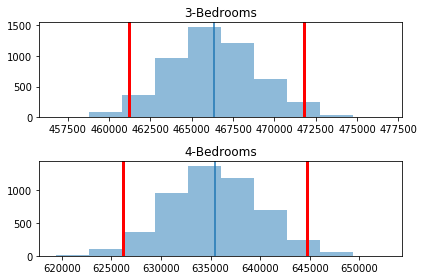

In [26]:
plot_dists(bed3, bed4, nbins=80, a_label='3-Bedrooms', b_label='4-Bedrooms')

The histogram below shows the bootstrap difference in means of 3 and 4 bedroom homes. We can see that the CI does not straddle 0. We can reject the null hypothesis.

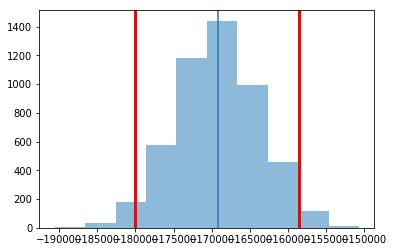

In [27]:
diffs = []
for i in range(n):
    sample = home.sample(frac=1.0, replace=True)
    three_sample_mean = sample[sample['bedrooms'] == 3].price.mean()
    four_sample_mean = sample[sample['bedrooms'] == 4].price.mean()
    diffs.append(three_sample_mean - four_sample_mean)
diffs = pd.Series(diffs)

plot_hist(diffs)

## Bayesian Method

Mean = 467243.503, Standard deviation = 266162.829
Mean = 636257.695, Standard deviation = 385246.252
The 0.950 credible interval is 0.025 to 0.975
The 0.950 credible interval is 0.025 to 0.975


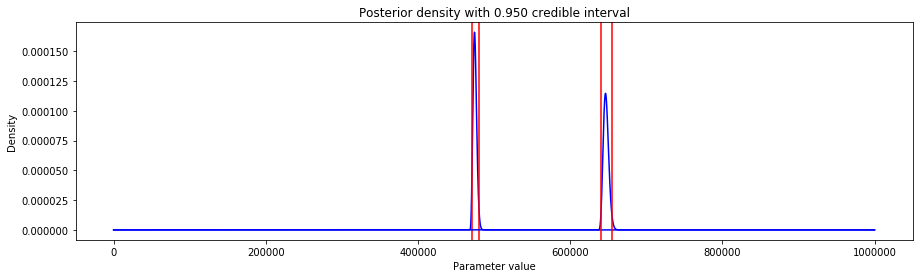

In [28]:
N = 1000000
p = np.linspace(0, 1000000, num=N)

num_samples = 5000


b3_sample = kc_house[kc_house.bedrooms == 3].sample(n=num_samples)
b4_sample = kc_house[kc_house.bedrooms == 4].sample(n=num_samples)

like_b3 = comp_like(p, b3_sample.price)
pp_b3 = ss.lognorm.pdf(p, s=0.9, loc = b3_sample.price.mean() , scale=b3_sample.price.std())
pp_b3 = pp_b3/pp_b3.sum()
post_b3 = posterior(pp_b3, like_b3)

like_b4 = comp_like(p, b4_sample.price)
pp_b4 = ss.lognorm.pdf(p, s=0.9, loc = b4_sample.price.mean(), scale=b4_sample.price.std())
pp_b4 = pp_b4/pp_b4.sum()
post_b4 = posterior(pp_b4, like_b4)

plt.figure(figsize=(15,4)).gca()
# Plotting the Posterior distributions and CIs
plot_ci(p, post_b3, num_samples, lower_q=.025, upper_q=.975)
plot_ci(p, post_b4, num_samples, lower_q=.025, upper_q=.975)

The Bayesian method shows the posterier densities of 3 and 4 bedroom homes. The graph demonstrates that the distributions do not overlap, and the confidence intervals do not overlap. Due to these reasons, we can reject the null hypothesis that the difference of means of homes with 3 and 4 bedrooms arrises from randomness.

This example shows that all three tests reject the null hypothesis